In [7]:
# Configuração inicial
import pandas as pd
import json
from sqlalchemy import create_engine
from sqlalchemy import text
from IPython.display import display

# Relatório Final

    1.  **Correção de dados**  
    ✔ Substituição de caracteres especiais  
    ✔ Conversão de tipos de dados  
    ✔ Padronização de colunas  

    2.  **Consultas SQL completas**  

    ✔ CTEs para cálculos complexos  
    ✔ Funções de janela (RANK, AVG)  
    ✔ JOINs entre tabelas  


    3.  **Análise estratégica de vendas**  
    ✔ Identificação de top modelos  
    ✔ Segmentação por faixa de preço  
    ✔ Comparativo de desempenho  


    4.  **Documentação organizada**  
    ✔ Relatório estruturado em seções  
    ✔ Explicações claras das métricas  
    ✔ Recomendações acionáveis  

# Pré-Processamento 

Indentificamos que os dados de entrada é formado por uma estrutura flexível (JSON), e este tipo de arquivo semi-estruturado,possui um tratamento que tem:

    ✔ Tem hierarquia definida (objetos, arrays)

    ✔ Mas não exige esquema rígido como bancos relacionais

Os arquivos broken_database_1.json e broken_database_2.json são exemplos típicos:

    Tem estrutura básica (arrays de objetos)

    Permitem variações entre registros

    Contêm metadados embutidos (nomes de campos)

    Flexibilidade para receber dados heterogêneos

    Facilidade de integração entre sistemas

    Conversão para formatos estruturados (ETL) quando necessário    

In [12]:
# Passo 1: extração dos dados semiestruturados 

with open('broken_database_1.json', 'r', encoding='utf-8') as f:
    vendas = pd.json_normalize(json.load(f))

with open('broken_database_2.json', 'r', encoding='utf-8') as f:
    marcas = pd.json_normalize(json.load(f))


✅ **Correção de dados**  
✔ Substituição de caracteres especiais 

In [9]:
# 2. Pré-processamento

def corrigir_caracteres(s):
    if pd.isna(s):
        return s
    return s.replace('æ', 'a').replace('ø', 'o').replace('å', 'a')

marcas['marca'] = marcas['marca'].apply(corrigir_caracteres)
vendas['nome'] = vendas['nome'].apply(corrigir_caracteres)
vendas['vendas'] = pd.to_numeric(vendas['vendas'], errors='coerce')
vendas = vendas.rename(columns={'id_marca_': 'id_marca'})


In [10]:
# 3. Configurar banco de dados
engine = create_engine('sqlite:///:memory:')  # Cria banco SQLite em memória (rápido para análise temporária)
vendas.to_sql('vendas', engine, index=False)  # Carrega DataFrame de vendas como tabela SQL
marcas.to_sql('marcas', engine, index=False)  # Carrega DataFrame de marcas como tabela SQL relacionável

11

Principais características da linha de código a seguir:

    execute_sql(): Para operações que alteram dados (requerem commit)

    query_sql(): Para consultas que retornam dados (converte para DataFrame)

    Uso de with: Garante que a conexão seja fechada automaticamente

    text(): Converte strings para comandos SQLAlchemy (mais seguro contra SQL injection)



In [13]:
# 4. Funções de consulta corrigidas

def execute_sql(query):
    """
    Executa comandos SQL de modificação (INSERT, UPDATE, DELETE)
    Parâmetros:
        query (str): Comando SQL a ser executado
    """
    with engine.connect() as conn:  # Cria conexão temporária
        conn.execute(text(query))  # Executa a query (text() converte para formato SQLAlchemy)
        conn.commit()  # Confirma as alterações no banco

def query_sql(query):
    """
    Executa consultas SQL (SELECT) e retorna resultados como DataFrame
    Parâmetros:
        query (str): Consulta SQL a ser executada
    Retorno:
        pd.DataFrame: Resultados da consulta em formato tabular
    """
    with engine.connect() as conn:  # Cria conexão temporária
        return pd.read_sql(text(query), conn)  # Converte resultado SQL diretamente para DataFrame

In [14]:
## 5. Executar consultas

try:
    print("1.4 Marcas sem vendas:")
    display(query_sql("""
    SELECT m.* FROM marcas m
    LEFT JOIN vendas v ON m.id_marca = v.id_marca
    WHERE v.id_marca IS NULL
    """))
    
    print("\n1.5 Marcas acima da média:")
    display(query_sql("""
    WITH media AS (
        SELECT marca, AVG(vendas) as media_vendas
        FROM vendas v JOIN marcas m ON v.id_marca = m.id_marca
        GROUP BY marca
    )
    SELECT v.id_marca, m.marca, v.vendas, media.media_vendas
    FROM vendas v
    JOIN marcas m ON v.id_marca = m.id_marca
    JOIN media ON m.marca = media.marca
    WHERE v.vendas > media.media_vendas
    """))
    
except Exception as e:
    print(f"Erro: {str(e)}")

    

1.4 Marcas sem vendas:


,id_marca,marca



1.5 Marcas acima da média:


,id_marca,marca,vendas,media_vendas
0,1,Fiat,40,19.681818
1,2,Volkswagen,35,18.809524
2,3,Kia,42,23.000000
3,7,Mitsubishi,4,3.800000
4,11,Renault,5,4.750000
5,2,Volkswagen,40,18.809524
6,1,Fiat,52,19.681818
7,3,Kia,30,23.000000
8,5,Toyota,15,7.875000
9,7,Mitsubishi,7,3.800000


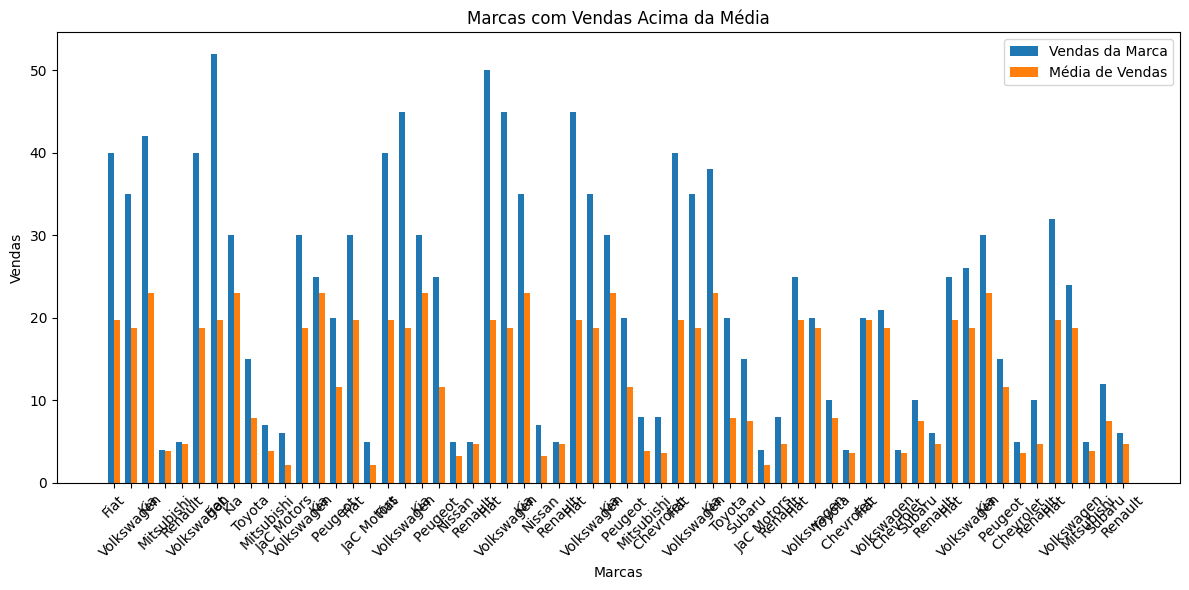

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# Executar a consulta e obter os dados
df_marcas_acima_media = query_sql("""
WITH media AS (
    SELECT marca, AVG(vendas) as media_vendas
    FROM vendas v JOIN marcas m ON v.id_marca = m.id_marca
    GROUP BY marca
)
SELECT v.id_marca, m.marca, v.vendas, media.media_vendas
FROM vendas v
JOIN marcas m ON v.id_marca = m.id_marca
JOIN media ON m.marca = media.marca
WHERE v.vendas > media.media_vendas
""")

# Criar gráfico de comparação
plt.figure(figsize=(12, 6))
x = range(len(df_marcas_acima_media))
width = 0.35

plt.bar(x, df_marcas_acima_media['vendas'], width, label='Vendas da Marca')
plt.bar([i + width for i in x], df_marcas_acima_media['media_vendas'], width, label='Média de Vendas')

plt.xlabel('Marcas')
plt.ylabel('Vendas')
plt.title('Marcas com Vendas Acima da Média')
plt.xticks([i + width/2 for i in x], df_marcas_acima_media['marca'], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

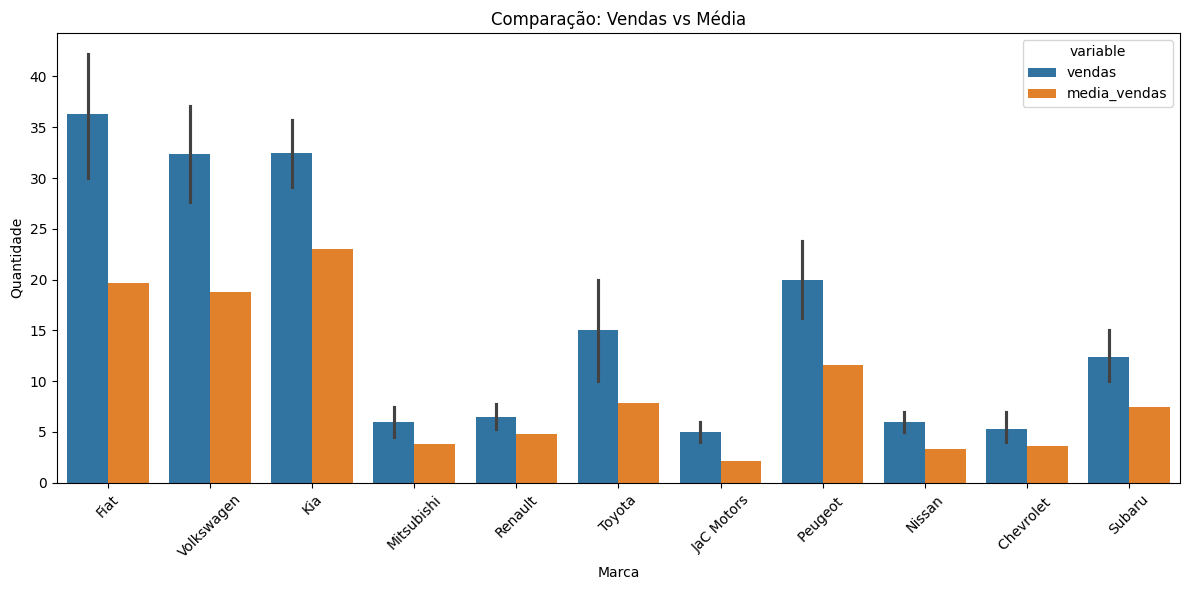

In [17]:
import seaborn as sns

# Gráfico para marcas acima da média
plt.figure(figsize=(12, 6))
sns.barplot(data=df_marcas_acima_media.melt(id_vars=['marca'], 
                                           value_vars=['vendas', 'media_vendas']),
            x='marca', y='value', hue='variable')
plt.title('Comparação: Vendas vs Média')
plt.xlabel('Marca')
plt.ylabel('Quantidade')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [37]:
print("\n7. Top 10 modelos mais rentáveis:")
top_modelos = query_sql("""
WITH modelo_stats AS (
    SELECT 
        m.marca,
        v.nome,
        SUM(v.vendas) AS total_vendas,
        SUM(v.vendas * v.valor_do_veiculo) AS receita_total,
        AVG(v.valor_do_veiculo) AS preco_medio,
        COUNT(DISTINCT strftime('%m', v.data)) AS meses_ativos
    FROM vendas v
    JOIN marcas m ON v.id_marca = m.id_marca
    GROUP BY m.marca, v.nome
)
SELECT 
    marca,
    nome,
    total_vendas,
    receita_total,
    preco_medio,
    ROUND(receita_total / total_vendas, 2) AS ticket_medio_real,
    ROUND(total_vendas / meses_ativos, 2) AS vendas_por_mes,
    ROUND((preco_medio - (SELECT AVG(valor_do_veiculo) FROM vendas)) / 
          (SELECT AVG(valor_do_veiculo) FROM vendas) * 100, 2) AS percentual_acima_media
FROM modelo_stats
ORDER BY receita_total DESC
LIMIT 10;
""")
display(top_modelos)


7. Top 10 modelos mais rentáveis:


,marca,nome,total_vendas,receita_total,preco_medio,ticket_medio_real,vendas_por_mes,percentual_acima_media
0,Fiat,Mobi,414,14747000,38666.666667,35620.0,34.0,-43.11
1,Volkswagen,Up,373,14368000,41000.000000,38520.0,31.0,-39.68
2,Kia,Picanto,338,13243000,41750.000000,39180.0,28.0,-38.58
3,Subaru,Forester,28,9800000,335000.000000,350000.0,7.0,392.86
4,Peugeot,208,90,7425000,82400.000000,82500.0,18.0,21.23
5,Toyota,Corolla,40,4368000,108000.000000,109200.0,10.0,58.89
6,Subaru,WRX,15,3750000,250000.000000,250000.0,15.0,267.80
7,Mitsubishi,Pajero,13,2680000,220000.000000,206153.0,6.0,223.67
8,Mitsubishi,L200,10,2580000,270000.000000,258000.0,5.0,297.23
9,Chevrolet,onix,33,1418400,43355.555556,42981.0,3.0,-36.21



7. Top 10 modelos mais rentáveis:


,marca,nome,total_vendas,receita_total,preco_medio,ticket_medio_real,vendas_por_mes,percentual_acima_media
0,Fiat,Mobi,414,14747000,38666.666667,35620.0,34.0,-43.11
1,Volkswagen,Up,373,14368000,41000.000000,38520.0,31.0,-39.68
2,Kia,Picanto,338,13243000,41750.000000,39180.0,28.0,-38.58
3,Subaru,Forester,28,9800000,335000.000000,350000.0,7.0,392.86
4,Peugeot,208,90,7425000,82400.000000,82500.0,18.0,21.23
5,Toyota,Corolla,40,4368000,108000.000000,109200.0,10.0,58.89
6,Subaru,WRX,15,3750000,250000.000000,250000.0,15.0,267.80
7,Mitsubishi,Pajero,13,2680000,220000.000000,206153.0,6.0,223.67
8,Mitsubishi,L200,10,2580000,270000.000000,258000.0,5.0,297.23
9,Chevrolet,onix,33,1418400,43355.555556,42981.0,3.0,-36.21


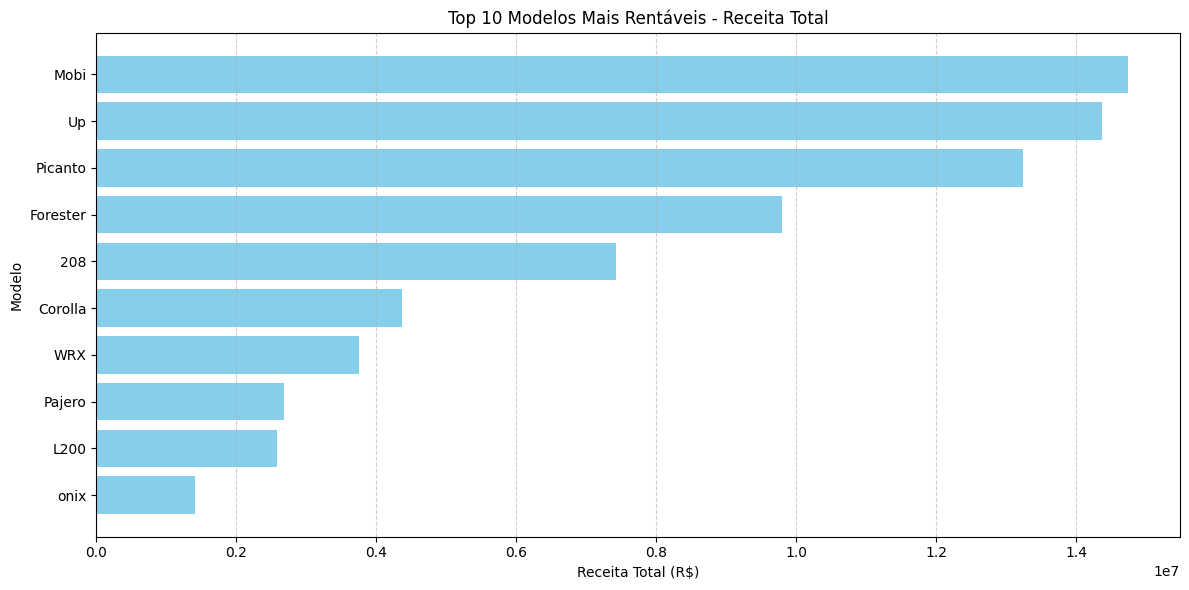

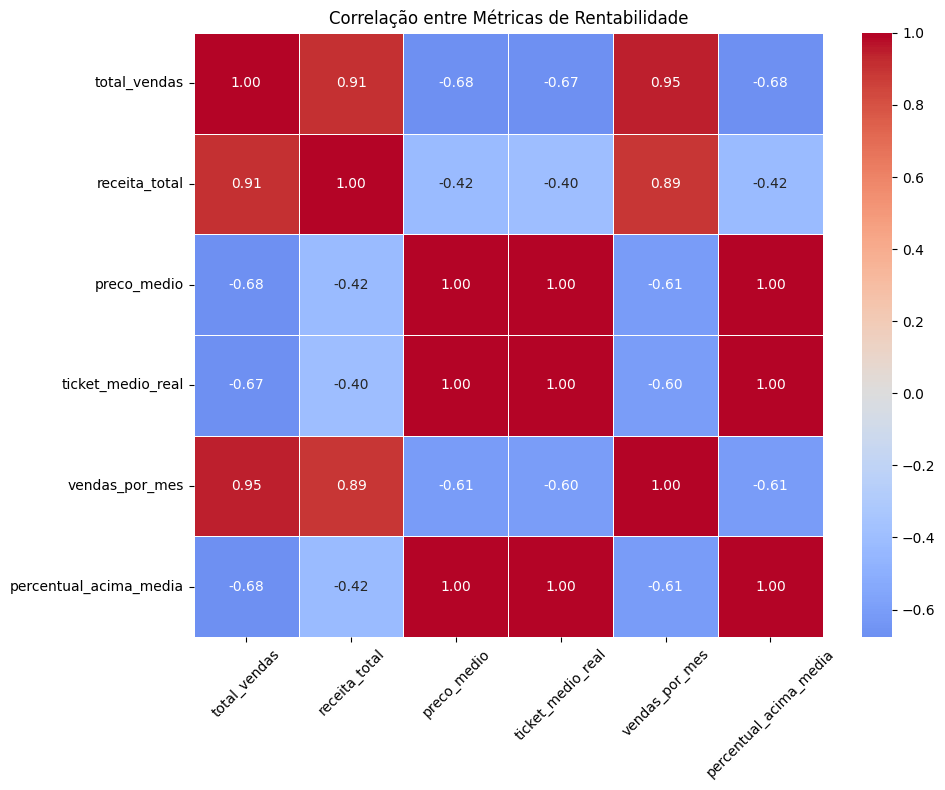

In [26]:
print("\n7. Top 10 modelos mais rentáveis:")
top_modelos = query_sql("""
WITH modelo_stats AS (
    SELECT 
        m.marca,
        v.nome,
        SUM(v.vendas) AS total_vendas,
        SUM(v.vendas * v.valor_do_veiculo) AS receita_total,
        AVG(v.valor_do_veiculo) AS preco_medio,
        COUNT(DISTINCT strftime('%m', v.data)) AS meses_ativos
    FROM vendas v
    JOIN marcas m ON v.id_marca = m.id_marca
    GROUP BY m.marca, v.nome
),
media_geral AS (
    SELECT AVG(valor_do_veiculo) as avg_valor FROM vendas
)
SELECT 
    marca,
    nome,
    total_vendas,
    receita_total,
    preco_medio,
    ROUND(receita_total / total_vendas, 2) AS ticket_medio_real,
    ROUND(total_vendas / meses_ativos, 2) AS vendas_por_mes,
    ROUND((preco_medio - (SELECT avg_valor FROM media_geral)) / 
          (SELECT avg_valor FROM media_geral) * 100, 2) AS percentual_acima_media
FROM modelo_stats
ORDER BY receita_total DESC
LIMIT 10;
""")

# Verificando se a consulta retornou dados
if top_modelos is not None and not top_modelos.empty:
    display(top_modelos)
    
    # Gráfico 1: Receita Total
    plt.figure(figsize=(12, 6))
    top_modelos = top_modelos.sort_values('receita_total', ascending=True)
    plt.barh(top_modelos['nome'], top_modelos['receita_total'], color='skyblue')
    plt.title('Top 10 Modelos Mais Rentáveis - Receita Total')
    plt.xlabel('Receita Total (R$)')
    plt.ylabel('Modelo')
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
    
    # Gráfico 2: Heatmap de Correlação
    numeric_cols = top_modelos.select_dtypes(include=['float64', 'int64']).columns
    corr_matrix = top_modelos[numeric_cols].corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f", linewidths=.5)
    plt.title('Correlação entre Métricas de Rentabilidade')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
else:
    print("Nenhum dado retornado pela consulta.")

In [27]:
print("\n9. Eficiência do mix de produtos por marca:")
mix_produtos = query_sql("""
WITH vendas_por_modelo AS (
    SELECT 
        m.marca,
        v.nome,
        SUM(v.vendas) AS total_vendas,
        SUM(v.vendas * v.valor_do_veiculo) AS receita_total
    FROM vendas v
    JOIN marcas m ON v.id_marca = m.id_marca
    GROUP BY m.marca, v.nome
),
marca_stats AS (
    SELECT
        marca,
        COUNT(nome) AS total_modelos,
        SUM(total_vendas) AS vendas_totais,
        SUM(receita_total) AS receita_total
    FROM vendas_por_modelo
    GROUP BY marca
)
SELECT 
    v.marca,
    v.nome,
    v.total_vendas,
    v.receita_total,
    ROUND(v.receita_total * 100.0 / m.receita_total, 2) AS contribuicao_receita,
    ROUND(v.total_vendas * 100.0 / m.vendas_totais, 2) AS contribuicao_vendas,
    CASE 
        WHEN ROUND(v.receita_total * 100.0 / m.receita_total, 2) > 20 THEN 'Alto impacto'
        WHEN ROUND(v.receita_total * 100.0 / m.receita_total, 2) > 5 THEN 'Médio impacto'
        ELSE 'Baixo impacto'
    END AS classificacao_impacto
FROM vendas_por_modelo v
JOIN marca_stats m ON v.marca = m.marca
ORDER BY v.marca, contribuicao_receita DESC;
""")
display(mix_produtos)


9. Eficiência do mix de produtos por marca:


,marca,nome,total_vendas,receita_total,contribuicao_receita,contribuicao_vendas,classificacao_impacto
0,Chevrolet,onix,33,1418400,100.00,100.00,Alto impacto
1,Fiat,Mobi,414,14747000,95.47,95.61,Alto impacto
2,Fiat,Cronos,4,320000,2.07,0.92,Baixo impacto
3,Fiat,Uno,8,191000,1.24,1.85,Baixo impacto
4,Fiat,argo,4,154000,1.00,0.92,Baixo impacto
5,Fiat,Palio,3,35000,0.23,0.69,Baixo impacto
6,JaC Motors,E-JS1,6,870000,60.84,23.08,Alto impacto
7,JaC Motors,E-J7,1,270000,18.88,3.85,Médio impacto
8,JaC Motors,J2,14,165000,11.54,53.85,Médio impacto
9,JaC Motors,J5,5,125000,8.74,19.23,Médio impacto


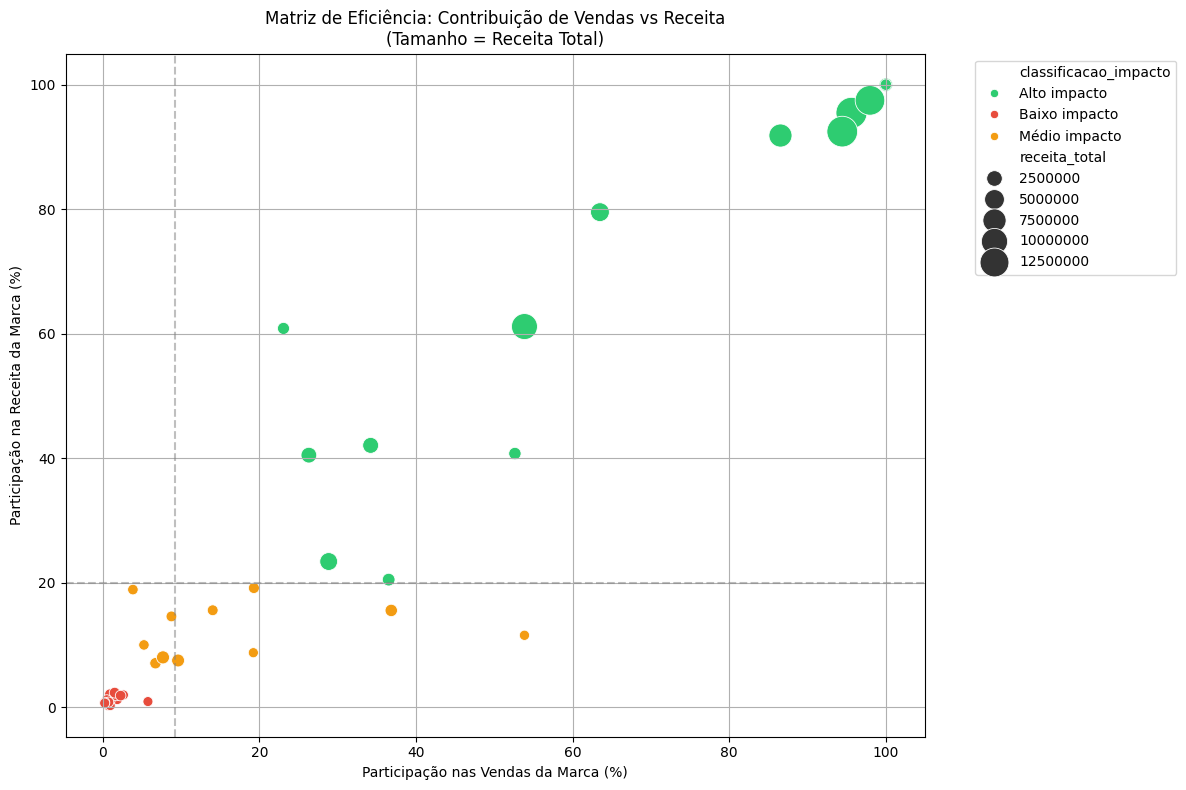

In [32]:
# Scatter Plot de Eficiência
plt.figure(figsize=(12, 8))
sns.scatterplot(data=mix_produtos, 
                x='contribuicao_vendas', 
                y='contribuicao_receita', 
                hue='classificacao_impacto',
                size='receita_total',
                sizes=(50, 500),
                palette={'Alto impacto':'#2ecc71', 'Médio impacto':'#f39c12', 'Baixo impacto':'#e74c3c'})

plt.title('Matriz de Eficiência: Contribuição de Vendas vs Receita\n(Tamanho = Receita Total)')
plt.xlabel('Participação nas Vendas da Marca (%)')
plt.ylabel('Participação na Receita da Marca (%)')
plt.axhline(20, color='gray', linestyle='--', alpha=0.5)
plt.axvline(mix_produtos['contribuicao_vendas'].median(), color='gray', linestyle='--', alpha=0.5)
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

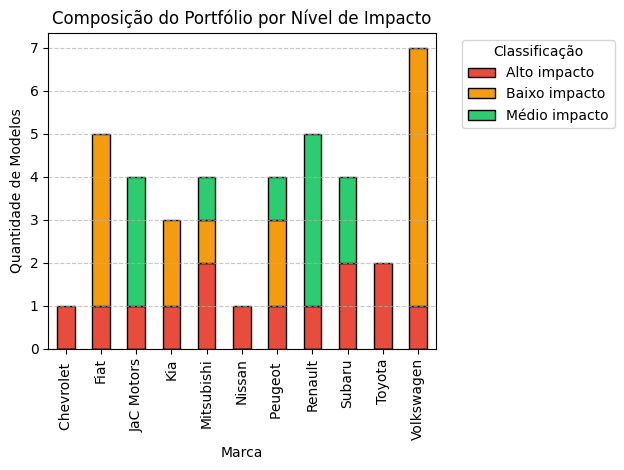

In [30]:
# Composição do portfólio por marca
pivot_table = mix_produtos.pivot_table(
    index='marca',
    columns='classificacao_impacto',
    values='nome',
    aggfunc='count',
    fill_value=0
)

plt.figure(figsize=(12, 6))
pivot_table.plot(kind='bar', stacked=True, 
                color=['#e74c3c','#f39c12','#2ecc71'],
                edgecolor='black')
plt.title('Composição do Portfólio por Nível de Impacto')
plt.ylabel('Quantidade de Modelos')
plt.xlabel('Marca')
plt.legend(title='Classificação', bbox_to_anchor=(1.05, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [39]:
!pip install plotly


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



   ---------------------------------------- 0.0/16.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/16.1 MB ? eta -:--:--
   -- ------------------------------------- 1.0/16.1 MB 4.2 MB/s eta 0:00:04
   ----- ---------------------------------- 2.1/16.1 MB 4.9 MB/s eta 0:00:03
   ------- -------------------------------- 3.1/16.1 MB 4.9 MB/s eta 0:00:03
   --------- ------------------------------ 3.9/16.1 MB 4.6 MB/s eta 0:00:03
   ------------- -------------------------- 5.2/16.1 MB 4.8 MB/s eta 0:00:03
   ---------------- ----------------------- 6.6/16.1 MB 5.0 MB/s eta 0:00:02
   ------------------- -------------------- 7.9/16.1 MB 5.1 MB/s eta 0:00:02
   ---------------------- ----------------- 8.9/16.1 MB 5.2 MB/s eta 0:00:02
   ------------------------ --------------- 10.0/16.1 MB 5.2 MB/s eta 0:00:02
   --------------------------- ------------ 11.3/16.1 MB 5.3 MB/s eta 0:00:01
   ------------------------------ --------- 12.3/16.1 MB 5.2 MB/s eta 0:00:01
   ------

In [45]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Gráfico 1: Sunburst (Hierarquia Marca-Modelo)
fig1 = px.sunburst(mix_produtos,
                  path=['marca', 'nome'],
                  values='receita_total',
                  color='contribuicao_receita',
                  color_continuous_scale='Blues',
                  title='Hierarquia de Receita por Marca e Modelo',
                  hover_data={'contribuicao_vendas': ':.1f%'},
                  height=600)

# Gráfico 2: Matriz 3D Interativa
fig2 = go.Figure()

for impacto, color in [('Alto impacto', '#2ecc71'), 
                      ('Médio impacto', '#f39c12'), 
                      ('Baixo impacto', '#e74c3c')]:
    df = mix_produtos[mix_produtos['classificacao_impacto'] == impacto]
    fig2.add_trace(go.Scatter3d(
        x=df['contribuicao_vendas'],
        y=df['contribuicao_receita'],
        z=df['receita_total'],
        mode='markers',
        name=impacto,
        marker=dict(
            color=color,
            size=df['receita_total']/100000,
            opacity=0.8
        ),
        text=df['marca'] + '<br>' + df['nome'],
        hoverinfo='text+x+y+z'
    ))



# Exibição dos gráficos
fig1.show()


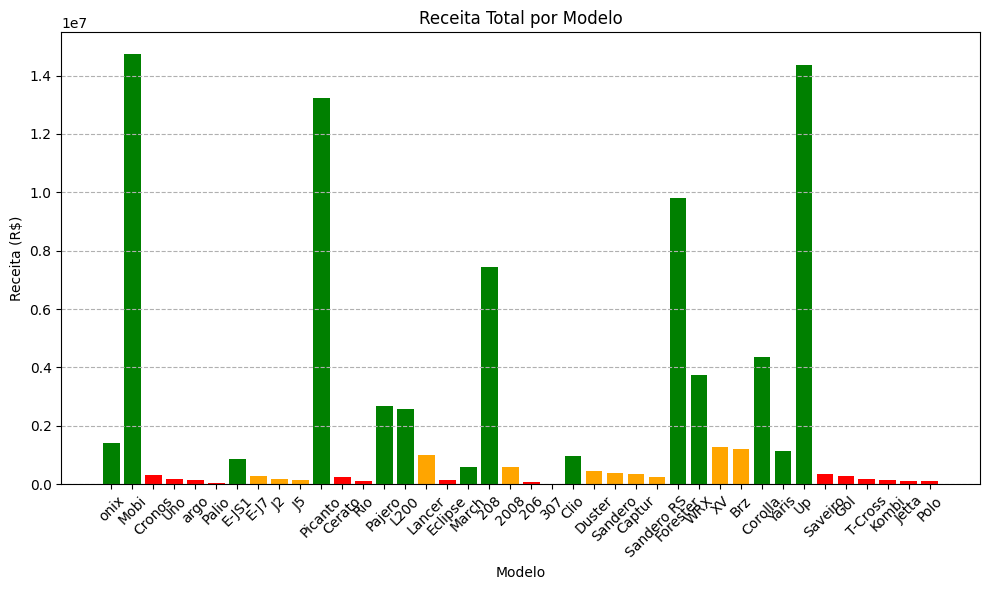

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
colors = {'Alto impacto': 'green', 'Médio impacto': 'orange', 'Baixo impacto': 'red'}
bar_colors = [colors[x] for x in mix_produtos['classificacao_impacto']]

plt.bar(mix_produtos['nome'], mix_produtos['receita_total'], color=bar_colors)
plt.title('Receita Total por Modelo')
plt.xlabel('Modelo')
plt.ylabel('Receita (R$)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

In [40]:
print("\n10. Sensibilidade de preço por modelo:")
elasticidade = query_sql("""
WITH preco_vendas AS (
    SELECT 
        nome,
        AVG(valor_do_veiculo) AS preco_medio,
        SUM(vendas) AS total_vendas,
        (SELECT AVG(valor_do_veiculo) FROM vendas) AS preco_medio_geral,
        (SELECT AVG(vendas) FROM vendas) AS media_vendas_geral
    FROM vendas
    GROUP BY nome
)
SELECT 
    p.nome,
    m.marca,
    p.preco_medio,
    p.total_vendas,
    p.preco_medio_geral,
    p.media_vendas_geral,
    ROUND((p.total_vendas - p.media_vendas_geral) / p.media_vendas_geral * 100, 2) AS diff_vendas_percentual,
    ROUND((p.preco_medio - p.preco_medio_geral) / p.preco_medio_geral * 100, 2) AS diff_preco_percentual,
    CASE
        WHEN (p.preco_medio < p.preco_medio_geral) AND (p.total_vendas > p.media_vendas_geral) THEN 'Volume alto - preço baixo'
        WHEN (p.preco_medio > p.preco_medio_geral) AND (p.total_vendas > p.media_vendas_geral) THEN 'Premium popular'
        WHEN (p.preco_medio > p.preco_medio_geral) AND (p.total_vendas < p.media_vendas_geral) THEN 'Nicho premium'
        ELSE 'Desempenho abaixo'
    END AS segmento_estrategico
FROM preco_vendas p
JOIN vendas v ON p.nome = v.nome
JOIN marcas m ON v.id_marca = m.id_marca
GROUP BY p.nome, m.marca
ORDER BY diff_preco_percentual;
""")
display(elasticidade)


10. Sensibilidade de preço por modelo:


,nome,marca,preco_medio,total_vendas,preco_medio_geral,media_vendas_geral,diff_vendas_percentual,diff_preco_percentual,segmento_estrategico
0,Palio,Fiat,11666.666667,3,67971.212121,11.886364,-74.76,-82.84,Desempenho abaixo
1,206,Peugeot,12000.000000,6,67971.212121,11.886364,-49.52,-82.35,Desempenho abaixo
2,J2,JaC Motors,12111.111111,14,67971.212121,11.886364,17.78,-82.18,Volume alto - preço baixo
3,307,Peugeot,19000.000000,1,67971.212121,11.886364,-91.59,-72.05,Desempenho abaixo
4,Uno,Fiat,22750.000000,8,67971.212121,11.886364,-32.70,-66.53,Desempenho abaixo
5,J5,JaC Motors,25000.000000,5,67971.212121,11.886364,-57.93,-63.22,Desempenho abaixo
6,March,Nissan,26428.571429,23,67971.212121,11.886364,93.50,-61.12,Volume alto - preço baixo
7,Clio,Renault,30600.000000,30,67971.212121,11.886364,152.39,-54.98,Volume alto - preço baixo
8,Gol,Volkswagen,32666.666667,9,67971.212121,11.886364,-24.28,-51.94,Desempenho abaixo
9,Sandero,Renault,38000.000000,8,67971.212121,11.886364,-32.70,-44.09,Desempenho abaixo


,nome,marca,preco_medio,total_vendas,preco_medio_geral,media_vendas_geral,diff_vendas_percentual,diff_preco_percentual,segmento_estrategico
0,Palio,Fiat,11666.666667,3,67971.212121,11.886364,-74.76,-82.84,Desempenho abaixo
1,206,Peugeot,12000.000000,6,67971.212121,11.886364,-49.52,-82.35,Desempenho abaixo
2,J2,JaC Motors,12111.111111,14,67971.212121,11.886364,17.78,-82.18,Volume alto - preço baixo
3,307,Peugeot,19000.000000,1,67971.212121,11.886364,-91.59,-72.05,Desempenho abaixo
4,Uno,Fiat,22750.000000,8,67971.212121,11.886364,-32.70,-66.53,Desempenho abaixo


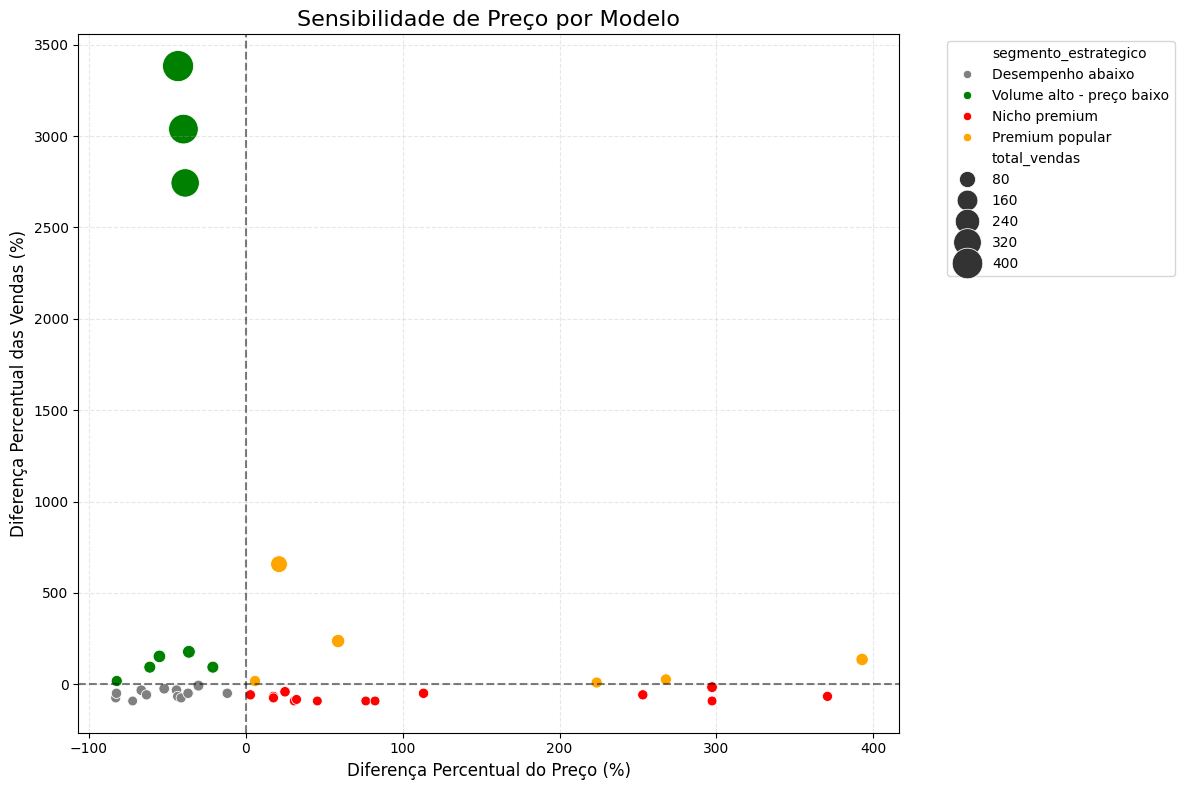

In [52]:
# 1. Executar a consulta SQL corrigida
elasticidade = query_sql("""
WITH preco_vendas AS (
    SELECT 
        v.nome,
        m.marca,
        AVG(v.valor_do_veiculo) AS preco_medio,
        SUM(v.vendas) AS total_vendas,
        (SELECT AVG(valor_do_veiculo) FROM vendas) AS preco_medio_geral,
        (SELECT AVG(vendas) FROM vendas) AS media_vendas_geral
    FROM vendas v
    JOIN marcas m ON v.id_marca = m.id_marca
    GROUP BY v.nome, m.marca
)
SELECT 
    nome,
    marca,
    preco_medio,
    total_vendas,
    preco_medio_geral,
    media_vendas_geral,
    ROUND((total_vendas - media_vendas_geral) / media_vendas_geral * 100, 2) AS diff_vendas_percentual,
    ROUND((preco_medio - preco_medio_geral) / preco_medio_geral * 100, 2) AS diff_preco_percentual,
    CASE
        WHEN (preco_medio < preco_medio_geral) AND (total_vendas > media_vendas_geral) THEN 'Volume alto - preço baixo'
        WHEN (preco_medio > preco_medio_geral) AND (total_vendas > media_vendas_geral) THEN 'Premium popular'
        WHEN (preco_medio > preco_medio_geral) AND (total_vendas < media_vendas_geral) THEN 'Nicho premium'
        ELSE 'Desempenho abaixo'
    END AS segmento_estrategico
FROM preco_vendas
ORDER BY diff_preco_percentual;
""")

# 2. Visualização dos dados
display(elasticidade.head())

# 3. Gráfico de Sensibilidade (Matplotlib)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=elasticidade,
    x='diff_preco_percentual',
    y='diff_vendas_percentual',
    hue='segmento_estrategico',
    size='total_vendas',
    sizes=(50, 500),
    palette={
        'Volume alto - preço baixo': 'green',
        'Premium popular': 'orange',
        'Nicho premium': 'red',
        'Desempenho abaixo': 'gray'
    }
)

plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.axvline(0, color='black', linestyle='--', alpha=0.5)
plt.title('Sensibilidade de Preço por Modelo', fontsize=16)
plt.xlabel('Diferença Percentual do Preço (%)', fontsize=12)
plt.ylabel('Diferença Percentual das Vendas (%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()





In [55]:
print("\n11. Recomendações estratégicas:")
recomendacoes = query_sql("""
WITH recomendacoes_base AS (
    SELECT
        m.marca,
        v.nome,
        SUM(v.vendas) AS total_vendas,
        SUM(v.vendas * v.valor_do_veiculo) AS receita_total,
        AVG(v.valor_do_veiculo) AS preco_medio,
        COUNT(DISTINCT strftime('%m', v.data)) AS meses_ativos,
        RANK() OVER (PARTITION BY m.marca ORDER BY SUM(v.vendas * v.valor_do_veiculo) DESC) AS rank_receita,
        RANK() OVER (PARTITION BY m.marca ORDER BY SUM(v.vendas) DESC) AS rank_vendas
    FROM vendas v
    JOIN marcas m ON v.id_marca = m.id_marca
    GROUP BY m.marca, v.nome
)
SELECT 
    marca,
    nome,
    total_vendas,
    receita_total,
    preco_medio,
    CASE
        WHEN rank_receita <= 3 AND rank_vendas <= 3 THEN 'Modelo estrela - manter/maximizar'
        WHEN rank_receita <= 3 AND rank_vendas > 3 THEN 'Alta receita - potencial para aumentar volume'
        WHEN rank_receita > 3 AND rank_vendas <= 3 THEN 'Alto volume - revisar margens'
        WHEN meses_ativos < 6 THEN 'Novo modelo - monitorar'
        ELSE 'Revisar estratégia'
    END AS recomendacao,
    CASE
        WHEN rank_receita <= 3 THEN 'Foco principal'
        WHEN rank_vendas <= 5 THEN 'Foco secundário'
        ELSE 'Revisão necessária'
    END AS prioridade
FROM recomendacoes_base
ORDER BY marca, rank_receita;
""")
display(recomendacoes)


11. Recomendações estratégicas:


,marca,nome,total_vendas,receita_total,preco_medio,recomendacao,prioridade
0,Chevrolet,onix,33,1418400,43355.555556,Modelo estrela - manter/maximizar,Foco principal
1,Fiat,Mobi,414,14747000,38666.666667,Modelo estrela - manter/maximizar,Foco principal
2,Fiat,Cronos,4,320000,80000.000000,Modelo estrela - manter/maximizar,Foco principal
3,Fiat,Uno,8,191000,22750.000000,Modelo estrela - manter/maximizar,Foco principal
4,Fiat,argo,4,154000,38500.000000,Alto volume - revisar margens,Foco secundário
5,Fiat,Palio,3,35000,11666.666667,Novo modelo - monitorar,Foco secundário
6,JaC Motors,E-JS1,6,870000,145000.000000,Modelo estrela - manter/maximizar,Foco principal
7,JaC Motors,E-J7,1,270000,270000.000000,Alta receita - potencial para aumentar volume,Foco principal
8,JaC Motors,J2,14,165000,12111.111111,Modelo estrela - manter/maximizar,Foco principal
9,JaC Motors,J5,5,125000,25000.000000,Alto volume - revisar margens,Foco secundário


In [56]:
try:
    # Exportar análises adicionais para JSON
    top_modelos.to_json('top_modelos.json', orient='records', indent=2)
    
    mix_produtos.to_json('mix_produtos.json', orient='records', indent=2)
    elasticidade.to_json('elasticidade.json', orient='records', indent=2)
    recomendacoes.to_json('recomendacoes.json', orient='records', indent=2)
    
    print("\nAnálises adicionais exportadas com sucesso:")
    print("- top_modelos.json")
    print("- mix_produtos.json")
    print("- elasticidade.json")
    print("- recomendacoes.json")
    
except Exception as e:
    print(f"\nErro ao exportar análises adicionais: {e}")


Análises adicionais exportadas com sucesso:
- top_modelos.json
- mix_produtos.json
- elasticidade.json
- recomendacoes.json


In [46]:
# 6. Exportar resultados
dados_completos = query_sql("SELECT v.*, m.marca FROM vendas v JOIN marcas m ON v.id_marca = m.id_marca")
dados_completos.to_json('dados_corrigidos.json', orient='records', indent=2)
marcas.to_json('marcas_corrigidas.json', orient='records', indent=2)
print("\nArquivos exportados com sucesso!")


Arquivos exportados com sucesso!
